In [1]:
import os
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy import stats, spatial
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
#plt.rcParams['font.family'] = 'Arial'

from scipy.optimize import curve_fit

def linear_function(x, a, b):
    return a * x + b

In [2]:
layer2 = {'layer_1': 'L1', 'layer_2': 'L2/3', 'layer_3': 'L2/3', 
          'layer_4': 'L4', 'layer_5': 'L5', 'layer_6': 'L6',
          'VISp2/3': 'L2/3', 'VISp4': 'L4', 'VISp5': 'L5',
          'VISp6a': 'L6', 'VISp6b': 'L6'
         }

In [3]:
soma_feature  = pd.read_excel('../../data/h01_metadata.xlsx')
soma_feature['swc_id'] = soma_feature['C3 agglomeration id'].astype(str) + '_sort.swc'
soma_feature = soma_feature.set_index('swc_id')
soma_feature['layer'] = soma_feature['Cell body layer'].map(layer2)

soma_feature

,C3 agglomeration id,Cell type,Cell body layer,E count all inputs,I count all inputs,E count layer 1,I count layer 1,E count layer 2,I count layer 2,E count layer 3,I count layer 3,E count layer 4,I count layer 4,E count layer 5,I count layer 5,E count layer 6,I count layer 6,E count white matter,I count white matter,layer
swc_id,,,,,,,,,,,,,,,,,,,,
4054157516_sort.swc,4054157516,excitatory/spiny neuron with atypical tree,layer_4,1016,436,0,0,0,0,308,113,562,288,146,35,0,0,0,0,L4
30451512536_sort.swc,30451512536,excitatory/spiny neuron with atypical tree,layer_2,1731,629,103,37,1628,592,0,0,0,0,0,0,0,0,0,0,L2/3
5393887098_sort.swc,5393887098,excitatory/spiny neuron with atypical tree,layer_5,612,403,0,0,0,0,0,0,27,5,585,398,0,0,0,0,L5
6908653613_sort.swc,6908653613,excitatory/spiny neuron with atypical tree,layer_5,701,399,0,0,0,0,0,0,54,22,647,377,0,0,0,0,L5
5490457849_sort.swc,5490457849,excitatory/spiny neuron with atypical tree,white_matter,1047,536,0,0,0,0,0,0,0,0,0,0,329,103,718,433,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8214144785_sort.swc,8214144785,unclassified neuron,white_matter,1,5,0,0,0,0,0,0,0,0,0,0,0,0,1,5,NaN
56645119749_sort.swc,56645119749,unclassified neuron,layer_5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,L5
97643429164_sort.swc,97643429164,unclassified neuron,layer_2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,L2/3


In [4]:
# soma_feature['Cell body layer'].to_dict()

In [5]:
den_contact = pd.read_csv('../../data/h01_swc_rm_tiny_synapse_branch_level.csv', 
                          sep=',', index_col=0)
den_contact = den_contact.reset_index(drop=True)
den_contact['cell_type'] = den_contact['swc_id'].map(soma_feature['layer'].to_dict())
den_contact

,##n,##n2,x,y,z,swc_id,synapse,branch_level,cell_type
0,28,28,2219.42,645.344,31.614,1069946936_sort.swc,y,1,L2/3
1,30,30,2219.81,644.832,31.713,1069946936_sort.swc,y,2,L2/3
2,38,38,2220.45,642.976,33.363,1069946936_sort.swc,y,2,L2/3
3,45,45,2221.79,641.280,33.033,1069946936_sort.swc,y,2,L2/3
4,56,56,2223.23,638.912,32.142,1069946936_sort.swc,y,2,L2/3
...,...,...,...,...,...,...,...,...,...
2551182,18187,18187,2677.47,741.120,15.939,985320716_sort.swc,y,1,L2/3
2551183,18190,18190,2676.93,741.696,15.378,985320716_sort.swc,y,1,L2/3
2551184,18197,18197,2675.46,742.880,14.322,985320716_sort.swc,y,1,L2/3
2551185,18210,18210,2673.92,745.984,12.375,985320716_sort.swc,y,1,L2/3


In [6]:
wide_df2_ = pd.crosstab(den_contact['cell_type'], 
                      den_contact['branch_level'], 
                     )
wide_df2_.columns.name = ''
wide_df2_.index.name = ''

wide_df2_

,1,2,3,4,5,6,7,8,9,10,...,82,83,84,85,86,87,88,89,90,91
,,,,,,,,,,,,,,,,,,,,,
L2/3,26062,59480,156457,243355,234483,194646,139064,100796,76915,64064,...,0,0,0,0,0,0,0,0,0,24
L4,20679,46240,75423,84183,72089,51802,41208,34302,28411,26338,...,0,0,0,0,0,0,0,0,0,0
L5,6419,12451,22150,24019,23621,17160,17553,15224,12020,11133,...,6,79,6,7,22,30,9,1,23,3
L6,3909,6042,9433,8239,9280,8361,7359,5844,4176,3133,...,6,46,16,4,4,9,4,23,24,30


In [7]:
soma_ct = soma_feature['layer'].value_counts()
soma_ct

layer
L2/3    7912
L4      2739
L5      2293
L6      1167
L1       553
Name: count, dtype: int64

In [8]:
for i in (wide_df2_.index):
    wide_df2_.loc[i, :] = wide_df2_.loc[i, :] / soma_ct[i]
    
wide_df2 = wide_df2_.copy()

wide_df2 = (wide_df2.T / wide_df2.sum(axis=1)).T
wide_df2

C:\Users\yishui\AppData\Local\Temp\ipykernel_66200\194640730.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.2939838220424673' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  wide_df2_.loc[i, :] = wide_df2_.loc[i, :] / soma_ct[i]
C:\Users\yishui\AppData\Local\Temp\ipykernel_66200\194640730.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7.517694641051567' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  wide_df2_.loc[i, :] = wide_df2_.loc[i, :] / soma_ct[i]
C:\Users\yishui\AppData\Local\Temp\ipykernel_66200\194640730.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '19.77464610717897' has dtype incompatible with int64, please explicitly cast to a com

,1,2,3,4,5,6,7,8,9,10,...,82,83,84,85,86,87,88,89,90,91
,,,,,,,,,,,,,,,,,,,,,
L2/3,0.016419,0.037471,0.098565,0.153310,0.147720,0.122624,0.087608,0.063500,0.048455,0.040359,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000015
L4,0.033462,0.074824,0.122047,0.136222,0.116652,0.083824,0.066681,0.055506,0.045974,0.042619,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
L5,0.028828,0.055919,0.099478,0.107872,0.106084,0.077067,0.078832,0.068372,0.053983,0.049999,...,0.000027,0.000355,0.000027,0.000031,0.000099,0.000135,0.000040,0.000004,0.000103,0.000013
L6,0.037976,0.058698,0.091641,0.080042,0.090155,0.081227,0.071492,0.056774,0.040570,0.030437,...,0.000058,0.000447,0.000155,0.000039,0.000039,0.000087,0.000039,0.000223,0.000233,0.000291


In [9]:
for i in range(1, max(wide_df2.columns)+1):
    if i not in list(wide_df2.columns):
        wide_df2[i] = 0

wide_df2 = wide_df2[list(range(1, 16))]
wide_df2

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
,,,,,,,,,,,,,,,
L2/3,0.016419,0.037471,0.098565,0.153310,0.147720,0.122624,0.087608,0.063500,0.048455,0.040359,0.032544,0.025582,0.024015,0.019603,0.016492
L4,0.033462,0.074824,0.122047,0.136222,0.116652,0.083824,0.066681,0.055506,0.045974,0.042619,0.034556,0.029303,0.029397,0.023447,0.018167
L5,0.028828,0.055919,0.099478,0.107872,0.106084,0.077067,0.078832,0.068372,0.053983,0.049999,0.047906,0.031285,0.028262,0.021611,0.019622
L6,0.037976,0.058698,0.091641,0.080042,0.090155,0.081227,0.071492,0.056774,0.040570,0.030437,0.032633,0.027532,0.025861,0.020800,0.015418


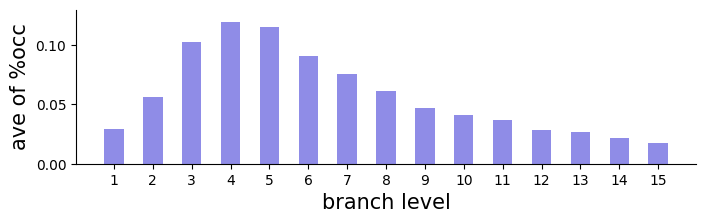

In [22]:
f,ax = plt.subplots(1,1,figsize=(8,2))
plt.bar([str(i) for i in list(wide_df2.columns)], 
        list(wide_df2.sum(axis=0) / len(wide_df2.index)),
        width=0.5, color='xkcd:perrywinkle'
       )
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim([0, 0.13])
plt.xlabel('branch level', fontsize=15)
plt.ylabel('ave of %occ', fontsize=15)
plt.savefig('./h01_dist.svg', bbox_inches='tight')
plt.show()


In [23]:
list(wide_df2.sum(axis=0) / len(wide_df2.index))

[0.029171193089699548,
 0.05672793946990226,
 0.1029327798490838,
 0.11936118509599389,
 0.11515281553355977,
 0.09118547507056107,
 0.07615348035144967,
 0.06103818544558329,
 0.047245369567188174,
 0.04085369969644586,
 0.03690965998489131,
 0.028425717906670242,
 0.026883961896869497,
 0.021365161906577078,
 0.01742467589544265]

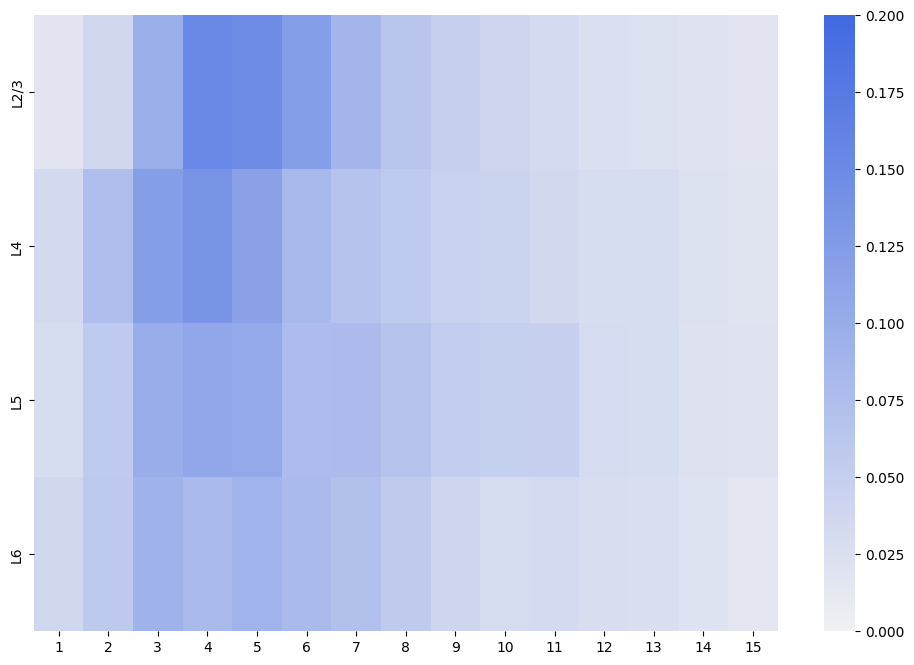

In [24]:
f,ax = plt.subplots(1,1,figsize=(12,8))
sns.heatmap((wide_df2), 
            vmin=0.00, 
            vmax=0.20,
            cmap=sns.color_palette("light:royalblue", as_cmap=True),
           )
# plt.xticks(np.arange(10, 80, 10)-0.5, [10, 20, 30, 40, 50, 60, 70])
plt.savefig('./h01_den_level_vis.svg', bbox_inches='tight')

In [25]:
pac_wide_df = pd.read_csv('../../data/ppss_from_pac_visp_wide_df.csv', 
                          sep=',', index_col=0)
pac_wide_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
VISp1,157,730,1436,2037,2392,2536,1945,1231,485,171,175,70,13,1,0,0
VISp2/3,793,2171,5068,6102,7851,6073,5062,3363,1543,915,482,140,134,9,0,0
VISp4,941,1643,2865,3580,4508,4590,3321,2148,1119,692,393,136,91,35,10,5
VISp5,773,2315,4066,4997,4532,3409,2455,1650,1014,488,136,108,29,15,0,0
VISp6a,148,512,1078,985,936,703,452,289,25,23,34,13,0,0,0,0
VISp6b,0,38,26,110,102,121,87,37,6,5,0,0,0,0,0,0


In [26]:
pac_wide_df = pd.read_csv('../../data/ppss_from_pac_visp_wide_df.csv', 
                          sep=',', index_col=0)
pac_wide_df = pac_wide_df.loc[['VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b'], [str(i) for i in (range(1,16))]]
pac_wide_df['layer'] = [layer2[i] for i in pac_wide_df.index]

pac_wide_df2 = pac_wide_df.groupby('layer').sum() 
pac_wide_df2 = (pac_wide_df2.T / pac_wide_df2.sum(axis=1)).T

pac_wide_df2

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
layer,,,,,,,,,,,,,,,
L2/3,0.019972,0.054677,0.127638,0.153680,0.197728,0.152949,0.127487,0.084698,0.038861,0.023044,0.012139,0.003526,0.003375,0.000227,0.000000
L4,0.036092,0.063018,0.109888,0.137312,0.172906,0.176051,0.127378,0.082387,0.042920,0.026542,0.015074,0.005216,0.003490,0.001342,0.000384
L5,0.029746,0.089083,0.156463,0.192288,0.174395,0.131181,0.094470,0.063493,0.039020,0.018779,0.005233,0.004156,0.001116,0.000577,0.000000
L6,0.025829,0.095986,0.192670,0.191099,0.181152,0.143805,0.094066,0.056894,0.005410,0.004887,0.005934,0.002269,0.000000,0.000000,0.000000


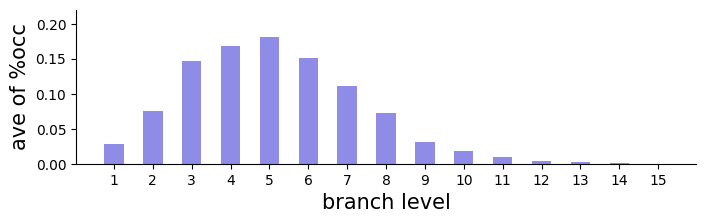

In [27]:
f,ax = plt.subplots(1,1,figsize=(8,2))
plt.bar([str(i) for i in list(pac_wide_df2.columns)], 
        list(pac_wide_df2.sum(axis=0) / len(pac_wide_df2.index)),
        width=0.5, color='xkcd:perrywinkle'
       )
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim([0, 0.22])

plt.xlabel('branch level', fontsize=15)
plt.ylabel('ave of %occ', fontsize=15)
plt.savefig('./pac_dist.svg', bbox_inches='tight')
plt.show()


In [28]:
stats.pearsonr(list(pac_wide_df2.sum(axis=0) / len(pac_wide_df2.index)), list(wide_df2.sum(axis=0) / len(wide_df2.index)))

PearsonRResult(statistic=0.9830450817312946, pvalue=5.836235680300103e-11)

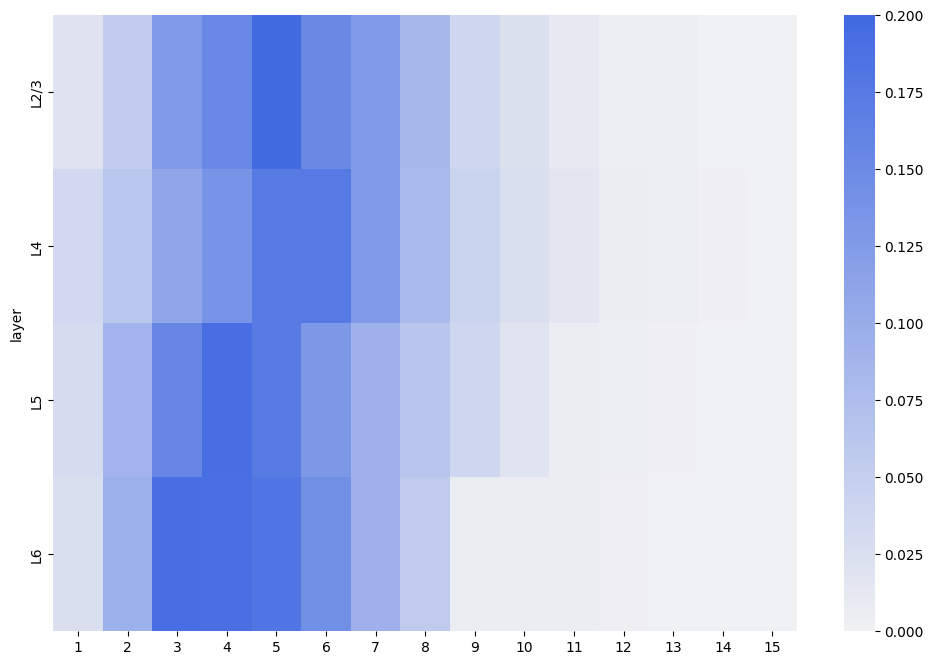

In [29]:
f,ax = plt.subplots(1,1,figsize=(12,8))
sns.heatmap((pac_wide_df2), 
            vmin=0.0, 
            vmax=0.20,
            cmap=sns.color_palette("light:royalblue", as_cmap=True),
           )
# plt.xticks(np.arange(10, 80, 10)-0.5, [10, 20, 30, 40, 50, 60, 70])
plt.savefig('./ppss_den_level_vis.svg', bbox_inches='tight')

In [30]:
tmp_list = []

for i in pac_wide_df2.index:
    for j in pac_wide_df2.columns:
        tmp_list.append([pac_wide_df2.loc[i, j], wide_df2.loc[i,int(j)]])

cmp_h01 = pd.DataFrame({'h01': [i[1] for i in tmp_list],
                          'ppss': [i[0] for i in tmp_list]
                         })

cmp_h01

,h01,ppss
0,0.016419,0.019972
1,0.037471,0.054677
2,0.098565,0.127638
3,0.153310,0.153680
4,0.147720,0.197728
5,0.122624,0.152949
6,0.087608,0.127487
7,0.063500,0.084698
8,0.048455,0.038861
9,0.040359,0.023044


In [31]:
print(stats.pearsonr(cmp_h01['h01'], cmp_h01['ppss']))

PearsonRResult(statistic=0.8927605677276983, pvalue=9.590685725174742e-22)


In [20]:
x = cmp_h01['h01']
y = cmp_h01['ppss']

params, covariance = curve_fit(linear_function, x, y)
a, b = params
x_fit = np.linspace(min(x), max(x), 100)
y_fit = linear_function(x_fit, a, b)

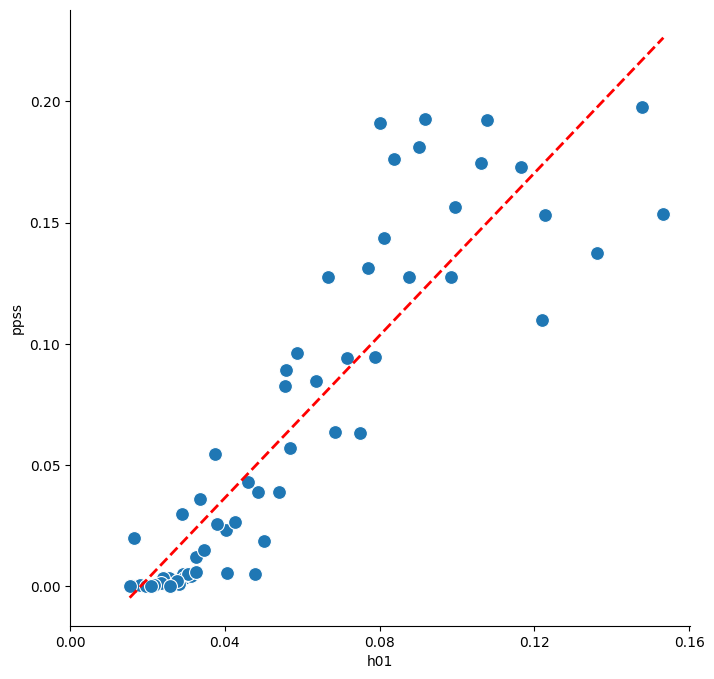

In [21]:
f,ax = plt.subplots(1,1,figsize=(8,8))
sns.scatterplot(data=cmp_h01,
                x='h01', y='ppss',
                s=100
               )
plt.plot(x_fit, y_fit, color='red', 
         linewidth=2, linestyle='--',
         label='Fitted Curve')

plt.xticks([0, 0.04, 0.08, 0.12, 0.16])
plt.yticks([0, 0.05, 0.10, 0.15, 0.20])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.savefig('./scatterplot_cmp_h01.jpg', dpi=800, bbox_inches='tight')
plt.savefig('./cmp_h01.svg', bbox_inches='tight')
plt.show()